In [ ]:
# Referenced from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
# All necessary imports here
import os
import sys
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import stellargraph as sg

import time

## Dataset

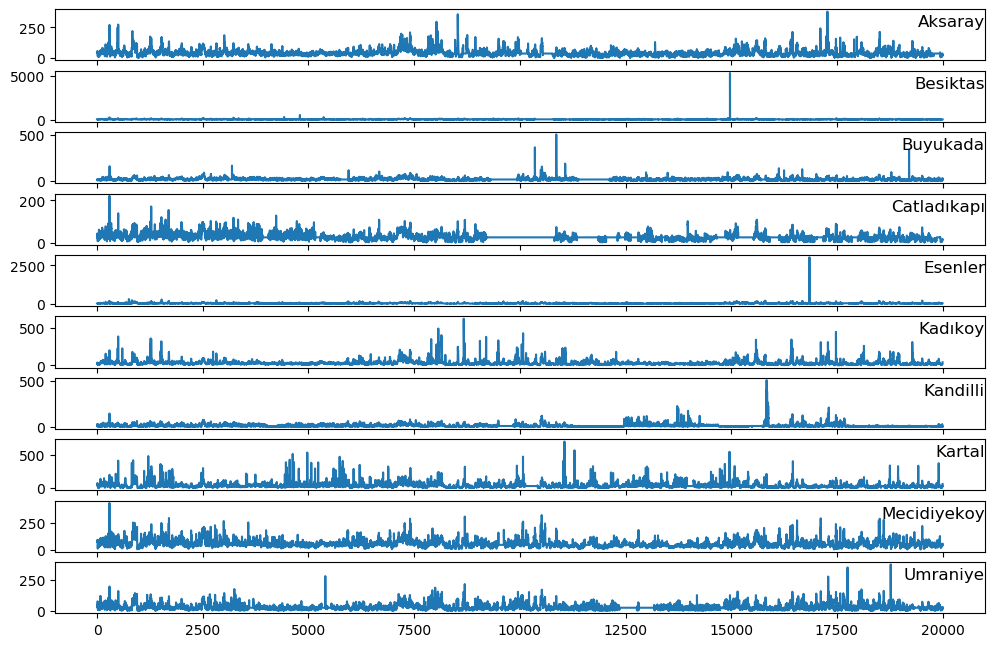

In [3]:
# load dataset
dataset = pd.read_excel(
     "datasets/training/PM10.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)
values = dataset.values
# specify columns to plot
groups = np.arange(1, 11)
i = 1
# plot each column
plt.figure(figsize=(12, 8), dpi=100)
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
# Train - Test split
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

# Scaling
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [5]:
#remove index column
dataset = dataset.iloc[: , 1:] 
dataset = dataset.T

#dataset info
num_nodes, time_len = dataset.shape

train_rate = 0.8
train_data, test_data = train_test_split(dataset, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
train_scaled, test_scaled = scale_data(train_data, test_data)
dataset

Train data:  (10, 16000)
Test data:  (10, 4000)


,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
Aksaray,42.200001,41.799999,44.200001,41.700001,49.700001,48.400002,51.400002,45.599998,50.200001,58.799999,...,33.900002,30.299999,35.400002,38.200001,30.000000,23.600000,25.900000,27.600000,19.700001,27.100000
Besiktas,37.599998,42.000000,39.000000,37.599998,48.500000,47.200001,62.700001,62.099998,59.400002,44.900002,...,21.000000,21.200001,12.800000,9.400000,15.400000,11.100000,17.400000,30.000000,18.600000,26.100000
Buyukada,9.600000,12.000000,12.800000,13.800000,16.400000,19.400000,17.900000,16.299999,13.200000,9.500000,...,6.700000,8.400000,15.900000,22.700001,20.299999,13.000000,8.700000,13.300000,30.600000,26.200001
Catladıkapı,24.100000,27.299999,40.200001,41.599998,40.900002,42.700001,38.099998,35.500000,26.299999,21.600000,...,11.000000,9.400000,8.200000,8.600000,10.300000,13.800000,17.200001,14.600000,14.800000,16.400000
Esenler,28.100000,34.200001,33.099998,33.799999,36.000000,42.200001,47.000000,42.200001,46.799999,47.400002,...,24.799999,25.200001,19.799999,17.799999,12.600000,12.200000,18.200001,18.299999,22.000000,31.299999
Kadıkoy,21.400000,24.200001,18.799999,18.000000,19.500000,23.299999,29.299999,33.099998,37.299999,29.799999,...,20.299999,15.900000,13.200000,12.500000,14.600000,14.400000,17.600000,24.000000,30.799999,41.200001
Kandilli,6.800000,5.300000,11.500000,13.400000,18.000000,21.000000,31.400000,19.000000,21.000000,12.800000,...,15.600000,12.600000,8.600000,6.300000,4.200000,3.800000,1.900000,1.000000,8.400000,1.100000
Kartal,46.599998,39.700001,49.299999,47.099998,48.799999,60.900002,64.500000,70.599998,76.900002,69.900002,...,18.500000,18.100000,23.000000,41.400002,34.400002,31.100000,26.600000,24.299999,24.200001,63.200001
Mecidiyekoy,73.320000,76.489998,77.769997,82.419998,82.059998,85.529999,89.029999,90.180000,92.879997,79.169998,...,46.389999,47.450001,48.290001,42.040001,51.669998,47.720001,41.580002,51.840000,53.709999,56.070000
Umraniye,34.200001,38.200001,45.400002,43.599998,47.000000,47.000000,45.799999,47.299999,42.799999,44.200001,...,21.100000,12.000000,22.600000,14.400000,19.299999,28.799999,21.400000,29.400000,23.200001,28.799999


In [6]:
# This value represents the past feature window size
seq_len = 10
# This value represents how far ahead we want to predict
pre_len = 12
# Data for LSTM is prepared using the Sliding Window approach
# Sliding windows are applied for each sensor
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [7]:
# We expect to see features of seq_len window size for each sensor 
# and labels as the pre_len ahead output
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(15979, 10, 10)
(15979, 10)
(3979, 10, 10)
(3979, 10)


## Model

Epoch 1/50
222/222 - 3s - loss: 0.0035 - val_loss: 0.0032
Epoch 2/50
222/222 - 1s - loss: 0.0033 - val_loss: 0.0032
Epoch 3/50
222/222 - 1s - loss: 0.0033 - val_loss: 0.0032
Epoch 4/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 5/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 6/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 7/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 8/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 9/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 11/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 12/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 13/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 14/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 15/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 16/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 17/50
222/222 - 1s - loss: 0.0032 - val_loss: 0.0032
Epoch 

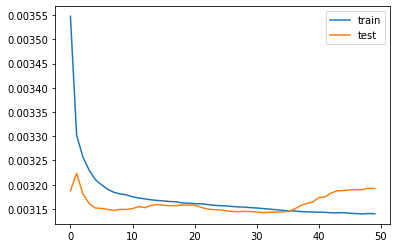

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=50, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()